In [64]:
import pandas as pd
import os
import numpy as np
import geopy.distance
import datetime
import geopandas
import matplotlib as matplotlib
import matplotlib.pyplot as plt

import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

import folium

## Main

In [63]:
path = "Data/"
raw_journeys = {} # Dictionary to hold raw journey data
processed_journeys = {} # Dictionary to hold processed data

for filename in os.listdir(path):
    if filename.endswith('.CSV'):
        route = os.path.splitext(filename)[0]
        raw_journeys[route] = read_file(filename, path)

for route,journey in raw_journeys.items():
    print("Processing journey:", route)
    
    getDistSlope(journey) # Augment journey dataframe with distance and slope columns
    minibus = Vehicle() # Instantiate vehicle object
    drvcycle = Drivecycle(journey) # Create drivecycle object with trip data
    
    # Compute energy expenditure (with and without regenerative braking)
    journey['Energy_Wh'] = minibus.getEnergyExpenditure(drvcycle)
    
    # Compute change in SoC at each timestep
    journey['SoC'] = np.array(journey['Energy_Wh'])/minibus.capacity/3.6e6 

    # Journey statistics
    print("Total estimated energy consumption for this route:", round(journey.Energy_Wh.sum()/3.6e6,2), "kWh")
    print("Total journey time:", round(journey.RelTime.max()/60,2), "minutes")
    print("Total journey distance:", round(journey.Distance_3D_km.sum(),2), "km")
    print("Estimated vehicle efficiency:", round((journey.Energy_Wh.sum()/3.6e6)/journey.Distance_3D_km.sum(),4), "kWh/km")
    print("% of battery charge left:", round(100*(1 - journey.SoC.sum()),2), "% \n \n")
    
    #Keep track of processed journey dataframes
    processed_journeys[key] = journey
    

Processing journey: KMDI - STB
Total estimated energy consumption for this route: 0.42 kWh
Total journey time: 7.75 minutes
Total journey distance: 2.71 km
Estimated vehicle efficiency: 0.1556 kWh/km
% of battery charge left: 99.58 % 
 

Processing journey: SW - STB
Total estimated energy consumption for this route: 8.89 kWh
Total journey time: 27.28 minutes
Total journey distance: 20.29 km
Estimated vehicle efficiency: 0.438 kWh/km
% of battery charge left: 91.11 % 
 

Processing journey: STB - KMDI
Total estimated energy consumption for this route: 1.89 kWh
Total journey time: 20.38 minutes
Total journey distance: 5.26 km
Estimated vehicle efficiency: 0.3603 kWh/km
% of battery charge left: 98.11 % 
 

Processing journey: STB - SW
Total estimated energy consumption for this route: 7.89 kWh
Total journey time: 40.92 minutes
Total journey distance: 20.33 km
Estimated vehicle efficiency: 0.3881 kWh/km
% of battery charge left: 92.11 % 
 



### Plot Drive Cycles

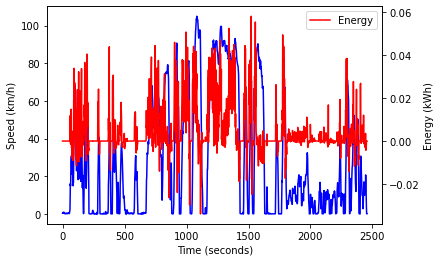

In [49]:
for filename, journey in processed_journeys.items():
    plotDriveCycle(journey)

In [50]:
def plotDriveCycle(journey):
    fig, ax = plt.subplots()
    ax.plot(journey['RelTime'], journey['Speed'], color = 'blue')
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Speed (km/h)")
    ax2 = ax.twinx() 
    ax2.plot(journey['RelTime'], journey['Energy_Wh']/3.6e6, color = "red")
    ax2.set_ylabel("Energy (kWh)")
    plt.legend()
    plt.show()
def plotDriveCycle_sep_axes(journey):
    fig, (ax1,ax2,ax3)= plt.subplots(3)
    fig.set_figheight(15)
    fig.set_figwidth(10)
    ax1.plot(journey['RelTime'], journey['Speed'])
    ax2.plot(journey['RelTime'], journey['Energy_Wh']/3.6e6)
    ax3.plot(journey['RelTime'], journey['Acceleration_dv_dt'])

## Functions

In [53]:
''' 
Takes in name of csv file with vehicle journey data
Returns augmented dataframe ready for analysis

TODO: Take out acceleration sanity check when no longer needed
'''
def read_file(filename, path):
    journey = pd.read_csv(path + filename)
   
    # Join date and time columns into one column, and drop individual columns
    journey['DateTime'] = pd.to_datetime(journey['Date'] + journey['Time'], format = '%m/%d/%Y%H:%M:%S')
    
    # Calculate time elapsed between each timestamp
    journey['DeltaT'] = journey['DateTime'] - journey['DateTime'].shift(1) 
    journey.DeltaT = journey['DeltaT']/ np.timedelta64(1, 's')# Convert from timedelta to float
    
    # Calculate acceleration from x,y,z-axis accelerations
    journey['Acceleration_measured'] = 9.80665 * journey['X-Axis Acceleration']
    # Acceleration using dV/dT
    journey['DeltaV'] = journey['Speed'] - journey['Speed'].shift(1) # creating this column for easier debugging
    journey['Acceleration_dv_dt'] = (journey['DeltaV']/3.6)/journey['DeltaT']
    
    # Relative time from start of journey, used for plotting drive cycle
    journey["RelTime"] = journey["DateTime"] - journey["DateTime"].min() 
    journey.RelTime = journey['RelTime']/ np.timedelta64(1, 's')# Convert from timedelta to float

    # Elevation change between each recording
    journey['ElevChange'] = journey['Altitude'] - journey["Altitude"].shift(1) # Ma y not be needed if don't use haversine function 
   
    # Joins Lat/Lon Coords into one column, useful for getDist function
    journey['Coordinates'] = list(zip(journey.Latitude, journey.Longitude)) 

    return journey

In [52]:
''' 
Inputs: dataframe with vehicle journey data

Calculates distance between each successive pair of lat/lon coordinates
(accounts for elevation difference)

Calculates slope angle faced by vehicle at each timestamp

TODO: decide arcsin or arccos approach. which is more accurate?

'''
def getDistSlope(journey):
    Distance = np.zeros(len(journey))
    Slope = np.zeros(len(journey))
    Slope_tan = np.zeros(len(journey))
    l_route = journey.shape[0]

    for i in range(1,l_route):
        elev_change = journey.Altitude.iloc[i]-journey.Altitude.iloc[i-1]
        dist_lateral = geopy.distance.geodesic(journey.Coordinates.iloc[i-1],  # Lateral distance in meters - dist between two lat/lon coord pairs
                                       journey.Coordinates.iloc[i]).m
        dist_3d = np.sqrt(dist_lateral**2 + elev_change**2)  # 3d dist -- accounting for elevation
        Distance[i] = dist_3d/1e3 # convert to km
        if Distance[i] != 0:
            Slope[i] = np.arcsin(elev_change/dist_3d)
    journey['Distance_3D_km'] = list(Distance)
    journey['slope_rad'] = list(Slope) 

In [4]:
# Simple functions that calculate four different types of forces acting on the vehicle, used in calculating total road load 
# based on examples shown here https://x-engineer.org/ev-design-energy-consumption/\

# Inertial Force
def getInertialForce(mass, accel):
    return mass * accel

# Road load (friction)
def getRoadFriction(mass, c_rr, slope, grav = 9.81): #c_rr is coeff of rolling resistance
    return mass * grav * c_rr * np.cos(slope)

# Aerodynamic Drag Force
def getAerodynamicDrag(c_d, A, vel, rho = 1.204): # rho is air density 20C, c_d is air drag coeff
    return 0.5 * rho * c_d * A * vel**2

# Road Slope Force
def getRoadSlopeDrag(mass, slope, grav = 9.81):
    return mass * grav * np.sin(slope)

In [62]:
class Vehicle:
    """
    Inputs: Physical parameters of vehicle for modeling energy consumption
    Returns an array of vehicle energy consumption at each timestamp
    
    mass - vehicle mass (kg)
    cd - coefficient of drag
    crr - coefficient of rolling resistance
    A - vehicle frontal area (m^2)
    eff - vehicle propulsion efficiency
    rgbeff - regenerative braking energy recuperation efficiency 
    cap - vehicle battery cap (kWh)
    p0 - constant power intake (W)
    """
    
    def __init__(self, mass = 2900, payload = 0,
                 cd = 0.5, crr = 0.01, A = 4,
                 eff = 0.8, rgbeff = 0.5, cap = 100, p0 = 100):

        # Vehicle physical parameters
        self.mass = mass # kg
        self.load = payload #kg
        self.crr = crr # coefficient of rolling resistance
        self.cd = cd  # air drag coefficient
        self.A = A # m^2, Approximation of vehicle frontal area 
        self.eff = eff
        self.rgbeff = rgbeff 
        self.capacity = cap 
        self.battery = cap
        self.p0 = p0 # constant power loss in W (to run the vehicle besides driving)
        
    def getEnergyExpenditure(self,cycle,regbrake = True):
        # computes energy expenditure from a Drivecycle object
        # dt default 1 second
        
        v = cycle.velocity/3.6 # m/s 
        s = cycle.slope # rad
        a = cycle.acceleration # m/s^2
        dt = cycle.dt # s
        d = cycle.displacement # m
        dv = cycle.dv
        
        if regbrake == True:
            RGBeff = self.rgbeff
        else:
            RGBeff = 0

            
        Fr = [] # Drag force: Inertia + Friction + Aero Drag + Slope Drag (N)
        Pr = [] # Total Power (W)
        Er = [] # Total energy consumption (J), from battery if positive, to battery if negative (RGbrake)
        for slope,vel,acc,delta_t,delta_v in zip(s,v,a,dt,dv):
            force = getInertialForce(self.mass, acc) + \
                    getRoadFriction(self.mass,self.crr, slope) + \
                    getAerodynamicDrag(self.cd, self.A, vel) + \
                    getRoadSlopeDrag(self.mass, slope)
           # exp_speed_delta = force * delta_t / self.mass
           # unexp_speed_delta = exp_speed_delta - delta_v
           # prop_force = unexp_speed_delta * delta_t / self.mass
            power = force * vel
            energy = power * delta_t
            Fr.append(force) # N
            Pr.append(power) # W
            Er.append(energy) # Wh


        
        Em_eff = [0.0]*len(Er)
        for i in range(len(Er)):
            if Er[i] > 0:
                Em_eff[i] = Er[i]/self.eff
            elif Er[i] < 0:
                Em_eff[i]= Er[i]*RGBeff   

       # adds constant loss p0 (100W)
        for i in range(len(Em_eff)):
            if v[i] > 0.50: # [m/s] to make sure that the vehicle is not parked (and engine maybe turned off)
                Em_eff[i] += self.p0
            else:
                Em_eff[i] = 0 
               
        # output in watt-hours
        return Em_eff

In [25]:
class Drivecycle: 
    """
    Inputs: dataframe with journey info
    """
    def __init__(self, journey): 
        self.displacement = journey.Distance_3D_km # m
        self.velocity = journey.Speed # km/h - make sure to convert to m/s before using in calcs
        self.acceleration = journey.Acceleration_dv_dt # m/s^2
        self.slope = journey.slope_rad # rad
        self.time = journey.RelTime.max() # Total Time Elapsed
        self.dt = journey.DeltaT # Time elapsed between each timestamp
        self.dv = journey.DeltaV
        
        

In [32]:
# Plotting route on Folium - ignore
for filename, journey in processed_journeys.items():
    map1 = folium.Map(
        location=[journey["Latitude"][1], journey["Longitude"][1]],
        tiles='cartodbpositron',
        zoom_start=12,
    )
    journey.apply(lambda row:folium.CircleMarker(location=[row["Latitude"], row["Longitude"]]).add_to(map1), axis=1)
    map1